## 读入图片以及特征关键点的文件，画出带有特征关键点的图片

### 导入所需要的库

In [1]:
import numpy as np
import cv2
from utils import draw_point, draw_delaunay, rect_contains
import matplotlib.pyplot as plt
%matplotlib inline

### 读入图片1和其对应的特征点，得到三角剖分的网格

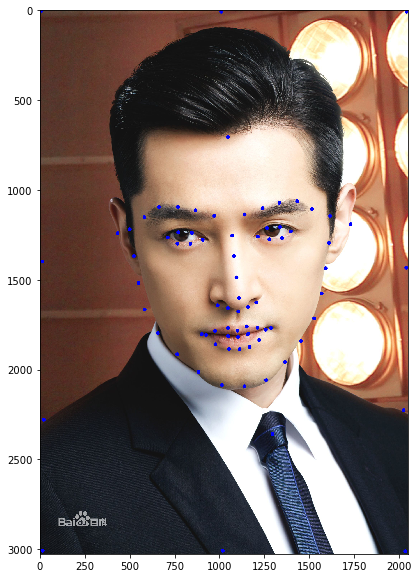

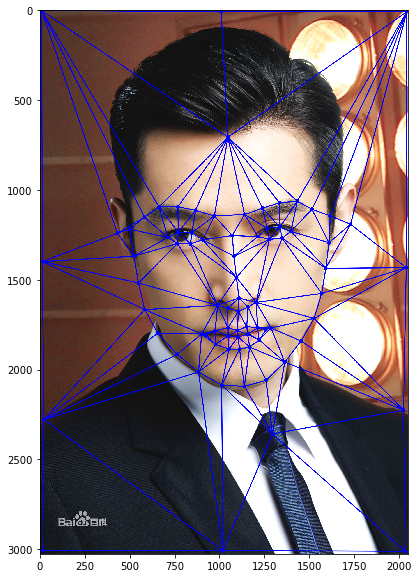

In [2]:
with open('./hugo.txt', 'r') as f:
    lines = f.readlines()

key_point1 = [(int(i.strip().split(',')[0]), int(i.strip().split(',')[1])) for i in lines]

img1 = cv2.imread('./hugo.jpg')
img_copy = img1.copy()
for p in key_point1:
    draw_point(img_copy, p, (255, 0, 0))

plt.figure(figsize=(10, 10))
plt.imshow(img_copy[:, :, ::-1])

rect1 = (0, 0, img_copy.shape[1], img_copy.shape[0])
sub_div1 = cv2.Subdiv2D(rect1)
for p in key_point1:
    sub_div1.insert(p)

draw_delaunay(img_copy, sub_div1, (255, 0, 0))
plt.figure(figsize=(10, 10))
plt.imshow(img_copy[:, :, ::-1])

### 读入图片2和其对应的特征点，得到三角剖分的网格

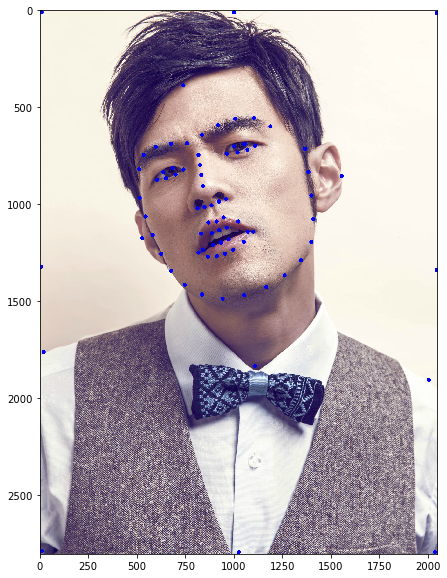

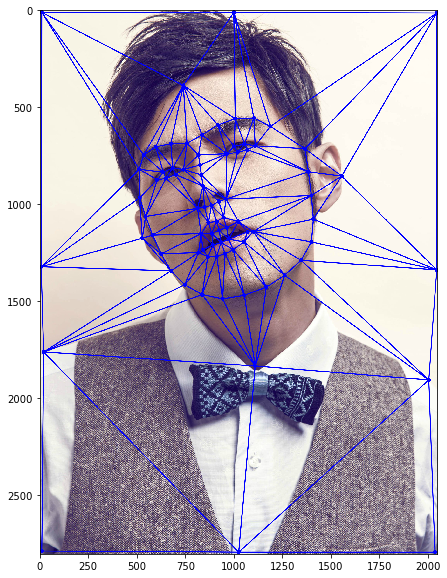

In [3]:
with open('./jay.txt', 'r') as f:
    lines = f.readlines()

key_point2 = [(int(i.strip().split(',')[0]), int(i.strip().split(',')[1])) for i in lines]

img2 = cv2.imread('./jay.jpg')
img_copy = img2.copy()

for p in key_point2:
    draw_point(img_copy, p, (255, 0, 0))

plt.figure(figsize=(10, 10))
plt.imshow(img_copy[:, :, ::-1])

rect2 = (0, 0, img2.shape[1], img2.shape[0])
sub_div2 = cv2.Subdiv2D(rect2)
for p in key_point2:
    sub_div2.insert(p)

draw_delaunay(img_copy, sub_div2, (255, 0, 0))
plt.figure(figsize=(10, 10))
plt.imshow(img_copy[:, :, ::-1])

### 计算Morph图片的加权特征点，得到对应的三角剖分网格

In [8]:
alpha = 0.5

points = []
for i in range(len(key_point1)):
    x = (1 - alpha) * key_point1[i][0] + alpha * key_point2[i][0]
    y = (1 - alpha) * key_point1[i][1] + alpha * key_point2[i][1]
    points.append((int(x), int(y)))

imgMorph = np.zeros(img1.shape, dtype=img1.dtype)

rect = (0, 0, imgMorph.shape[1], imgMorph.shape[0])
sub_div = cv2.Subdiv2D(rect)
for p in points:
    sub_div.insert(p)

### 建立三张图片三角剖分的对应索引

In [9]:
tri_list = sub_div.getTriangleList()

delaunayTri = []
pt = []
count = 0
for t in tri_list:
    pt.append((t[0], t[1]))
    pt.append((t[2], t[3]))
    pt.append((t[4], t[5]))
    
    pt1 = (t[0], t[1])
    pt2 = (t[2], t[3])
    pt3 = (t[4], t[5])
    
    if rect_contains(rect, pt1) and rect_contains(rect, pt2) and rect_contains(rect, pt3):
        count += 1
        idx = []
        for j in range(3): # 对三角形三个点进行考虑
            for k in range(len(points)): # 对所有的点进行遍历
                if abs(pt[j][0] - points[k][0]) < 1.0 and abs(pt[j][1] - points[k][1]) < 1.0:
                    idx.append(k)
        if len(idx) == 3:
            delaunayTri.append((idx[0], idx[1], idx[2]))
    pt = []

### 构建三角形的仿射变换，并将其应用于两张图原始图片，得到Morph图片

In [10]:
for (x, y, z) in delaunayTri:

    t1 = [key_point1[x], key_point1[y], key_point1[z]]
    t2 = [key_point2[x], key_point2[y], key_point2[z]]
    t = [points[x], points[y], points[z]]

    r1 = cv2.boundingRect(np.float32([t1]))
    r2 = cv2.boundingRect(np.float32([t2]))
    r = cv2.boundingRect(np.float32([t]))

    t1Rect = []
    t2Rect = []
    tRect = []

    for i in range(3):
        tRect.append(((t[i][0] - r[0]), (t[i][1] - r[1])))
        t1Rect.append(((t1[i][0] - r1[0]), (t1[i][1] - r1[1])))
        t2Rect.append(((t2[i][0] - r2[0]), (t2[i][1] - r2[1])))

    mask = np.zeros((r[3], r[2], 3), dtype=np.float32)

    cv2.fillConvexPoly(mask, np.int32(tRect), (1.0, 1.0, 1.0), 16, 0)

    img1Rect = img1[r1[1]:r1[1] + r1[3], r1[0]:r1[0] + r1[2]]
    img2Rect = img2[r2[1]:r2[1] + r2[3], r2[0]:r2[0] + r2[2]]

    size = (r[2], r[3])

    warpMat = cv2.getAffineTransform(np.float32(t1Rect), np.float32(tRect))

    dst1 = cv2.warpAffine(img1Rect, warpMat, (size[0], size[1]))

    warpMat = cv2.getAffineTransform(np.float32(t2Rect), np.float32(tRect))

    dst2 = cv2.warpAffine(img2Rect, warpMat, (size[0], size[1]))

    imgRect = (1 - alpha) * dst1 + alpha * dst2

    imgMorph[r[1]:r[1]+r[3], r[0]:r[0]+r[2]] = (1 - mask) * imgMorph[r[1]:r[1] + r[3], r[0]:r[0]+r[2]] + mask * imgRect

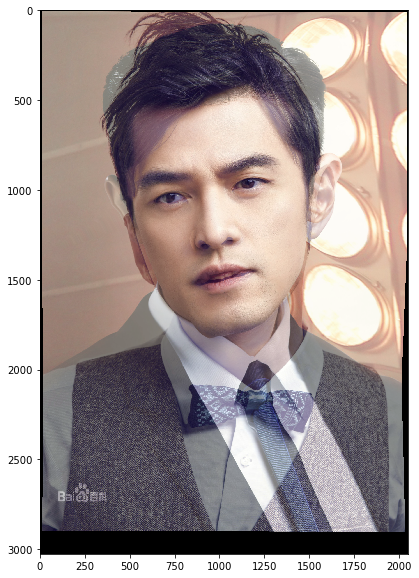

In [11]:
plt.figure(figsize=(10, 10))
plt.imshow(imgMorph[:, :, ::-1])